# 大数据分析第一次实验代码
姓名：刘培源

学号：2023214278

日期：2023年11月14日

### 数据读取

In [1]:
import pandas as pd

df = pd.read_excel('data.xlsx', sheet_name='data')

print(f"数据集的形状为：{df.shape}")
print(f"数据集的列名为：\n{list(df.columns)}")

数据集的形状为：(2040, 14)
数据集的列名为：
['群名', '群类别', '群人数', '消息数', '稠密度', '性别比', '平均年龄', '年龄差', '地域集中度', '手机比例', '会话数', '无回应比例', '夜聊比例', '图片比例']


### 定义辅助函数如下：
- `plot_data_normality`用于生成并保存一组数据的PDF、散点图和[Q-Q图](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot)。
-  `kstest`通过执行Kolmogorov-Smirnov检验来判断一组数据是否符合正态分布。
- `one_way_ANOVA`执行单变量方差分析。

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

def plot_data_normality(data, name):
    """
    Generates and saves a scatter plot, a histogram/KDE plot, and a Q-Q plot for the given data.

    Parameters:
    data (pd.Series): Data series to be plotted and analyzed.
    name (str): Name of the file to save the plots.
    """
    
    # Create a figure with three subplots
    _, (ax3, ax2, ax1) = plt.subplots(3, 1, figsize=(10, 9))

    # Scatter Plot
    ax1.scatter(data.index, data.values, color='blue', edgecolor='k')
    ax1.set_title('Scatter Plot of Data')
    ax1.set_ylabel('Values')
    ax1.grid(True)

    # Histogram and KDE
    data.hist(bins=30, alpha=0.5, ax=ax2, color='skyblue', edgecolor='k')
    data.plot(kind='kde', secondary_y=True, ax=ax2, color='red')
    ax2.set_title('Histogram and Kernel Density Estimation')
    ax2.grid(True)

    # Q-Q Plot
    data = data.sort_values()
    stats.probplot(data, dist="norm", plot=ax3)
    ax3.get_lines()[0].set_markersize(1)  # Adjust the marker size here
    ax3.set_title('Q-Q Plot')

    # Saving the figure
    plt.tight_layout()
    plt.savefig(f"{name}.png", dpi=300)

# Kolmogorov-Smirnov test
def kstest(data):
    return stats.kstest(data, 'norm', (data.mean(), data.std()))

# one-way ANOVA
from scipy import stats

def one_way_ANOVA(df, category_column, target='平均年龄'):
    """
    Conducts a one-way ANOVA test on a specified numeric column across different 
    categories defined in another column.
    
    Parameters:
    df : pandas.DataFrame
        DataFrame containing the data with at least two columns: one for the numeric 
        values and one for the category labels.
    category_column : str
        The column name in the DataFrame that contains the category labels.
    
    Output:
    Prints out the sample size, mean, standard deviation, and variance for each 
    group and the overall data. Also prints the between-group sum of squares (SS_b), 
    within-group sum of squares (SS_w), and their respective mean squares (MS_b, MS_w).
    Finally, prints the F-value and P-value from the ANOVA test.
    """
    sum_squares_between = 0
    sum_squares_within = 0
    overall_mean = df[target].mean()
    group_statistics = []

    # Iterate over each category to calculate group statistics and sum of squares
    for category in sorted(df[category_column].unique()):
        group_data = df[df[category_column] == category][target]
        group_size = group_data.count()
        group_mean = group_data.mean()
        group_std = group_data.std(ddof=1)  # ddof=1 for sample standard deviation
        group_var = group_std**2
        
        # Print group statistics
        print(f"Group {category}: n={group_size}, mean={group_mean:.2f}, std={group_std:.2f}, var={group_var:.2f}")
        
        # Append group statistics for output
        group_statistics.append((group_size, group_mean, group_std, group_var))
        
        # Calculate sum of squares
        sum_squares_between += group_size * (group_mean - overall_mean) ** 2
        sum_squares_within += ((group_data - group_mean) ** 2).sum()

    # Calculate degrees of freedom
    df_between = len(df[category_column].unique()) - 1
    df_within = df.shape[0] - len(df[category_column].unique())

    # Calculate mean squares
    mean_square_between = sum_squares_between / df_between
    mean_square_within = sum_squares_within / df_within

    # F statistic
    F_value = mean_square_between / mean_square_within

    # Perform the ANOVA test using scipy
    _, p_value = stats.f_oneway(*[df[df[category_column] == category][target] for category in df[category_column].unique()])

    # Print overall statistics and ANOVA results
    print(f"Overall: n={df.shape[0]}, mean={overall_mean:.2f}, std={df[target].std(ddof=1):.2f}, var={df[target].var(ddof=1):.2f}")
    print(f"SS_between={sum_squares_between:.2f}, SS_within={sum_squares_within:.2f}, Total_SS={sum_squares_between + sum_squares_within:.2f}")
    print(f"MS_between={mean_square_between:.2f}, MS_within={mean_square_within:.2f}")
    print(f"F_value={F_value:.2f}, p_value={p_value:.2e}")


### 实验3.1
绘制$\text{Col}[7]$的经验概率密度函数，即平均年龄的经验pdf。这个维度中的数据遵循高斯分布吗？测试$\text{Col}[7]$的正态性。

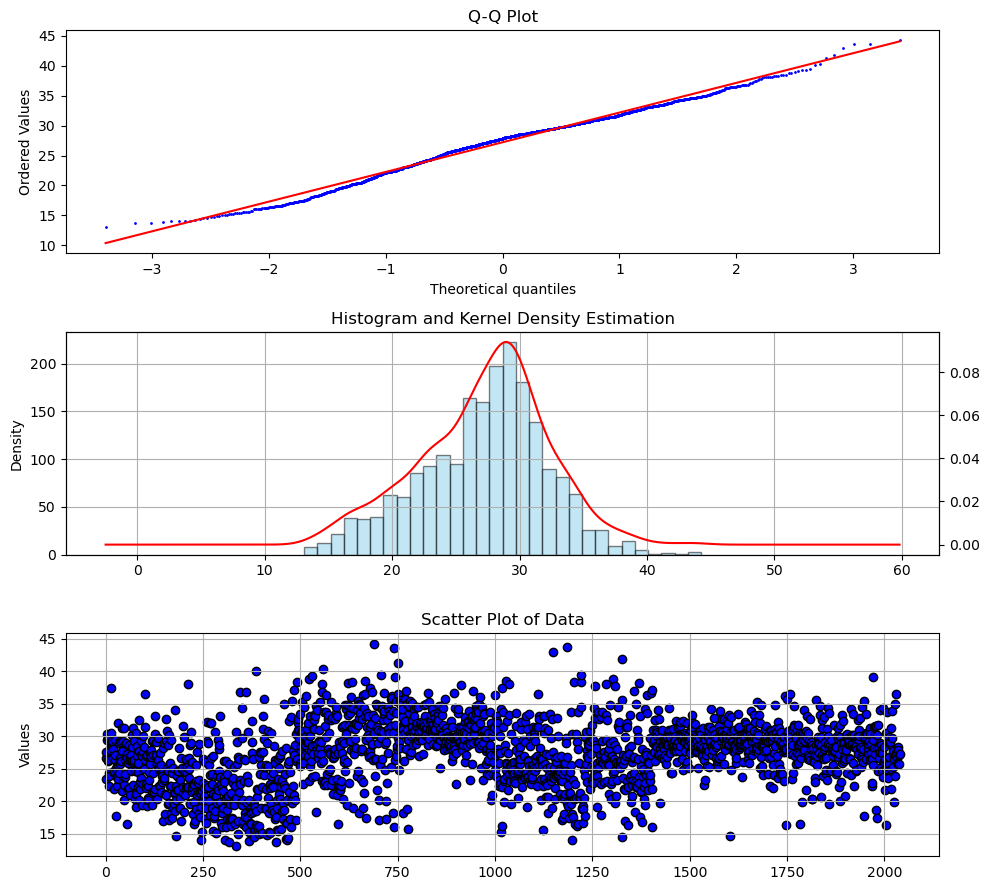

In [3]:
plot_data_normality(df.iloc[:, 6], 'exp3.1')

In [4]:
# 测试正态性
print(f"The p-value of Kolmogorov-Smirnov test: {kstest(df.iloc[:, 6]).pvalue}")

The p-value of Kolmogorov-Smirnov test: 8.012343213416506e-06


### 实验3.2
在$\text{Col}[7]$中，根据类别标签分为5个组成部分。我们将$\text{Col}[7]$中属于类别 \(i\) 的数据（其中 $i = 1, \ldots, 5$）表示为 $\text{Col}[7|\text{category}=i]$。测试每个组成部分的正态性以及方差的同质性。

The p-value of category 1 by kstest: 0.2704200562492669
The std of category 1: 4.923757137352908

The p-value of category 2 by kstest: 0.5763857287698038
The std of category 2: 5.217370879308969

The p-value of category 3 by kstest: 0.7103322292131584
The std of category 3: 2.5529012867875838

The p-value of category 4 by kstest: 0.01901321646759231
The std of category 4: 5.098255869880322

The p-value of category 5 by kstest: 0.0004048051678892366
The std of category 5: 3.018978805076039



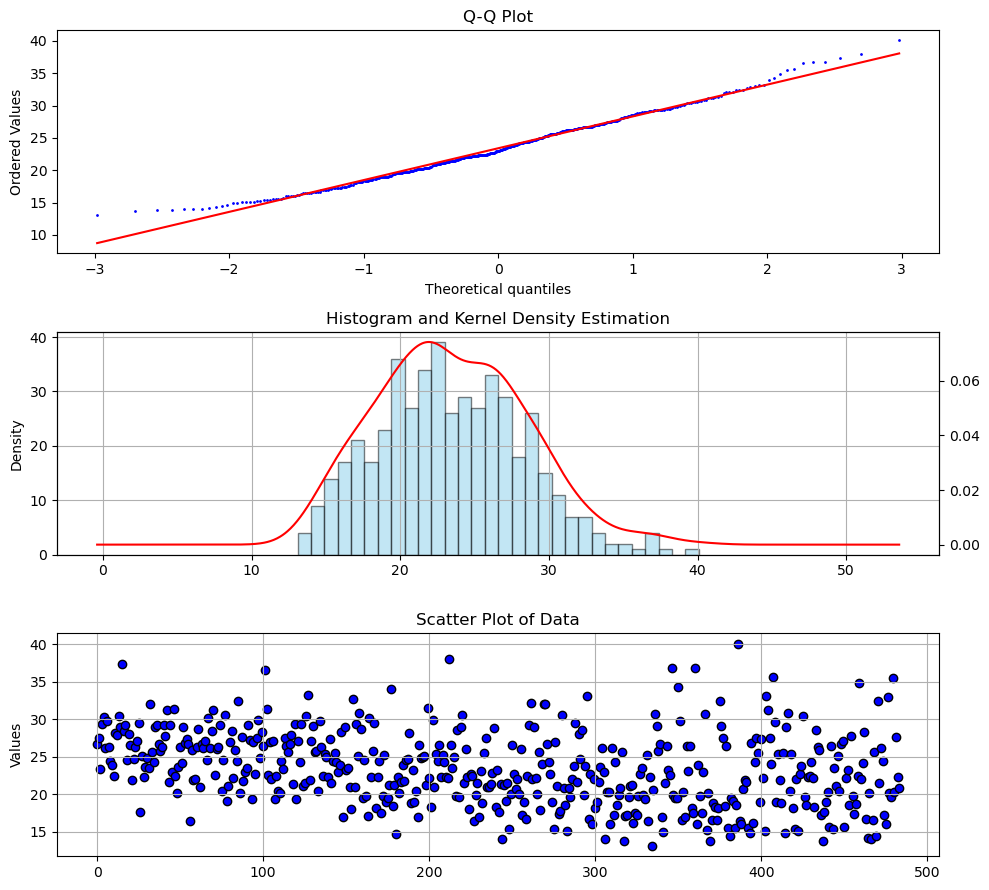

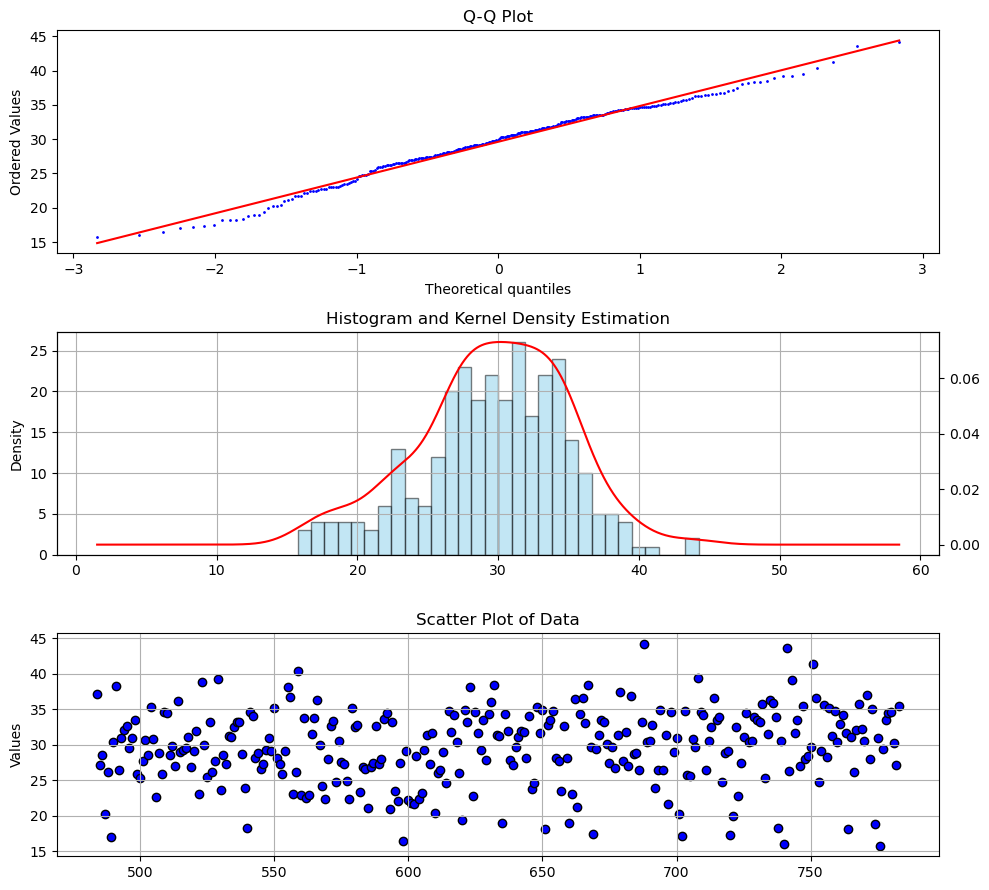

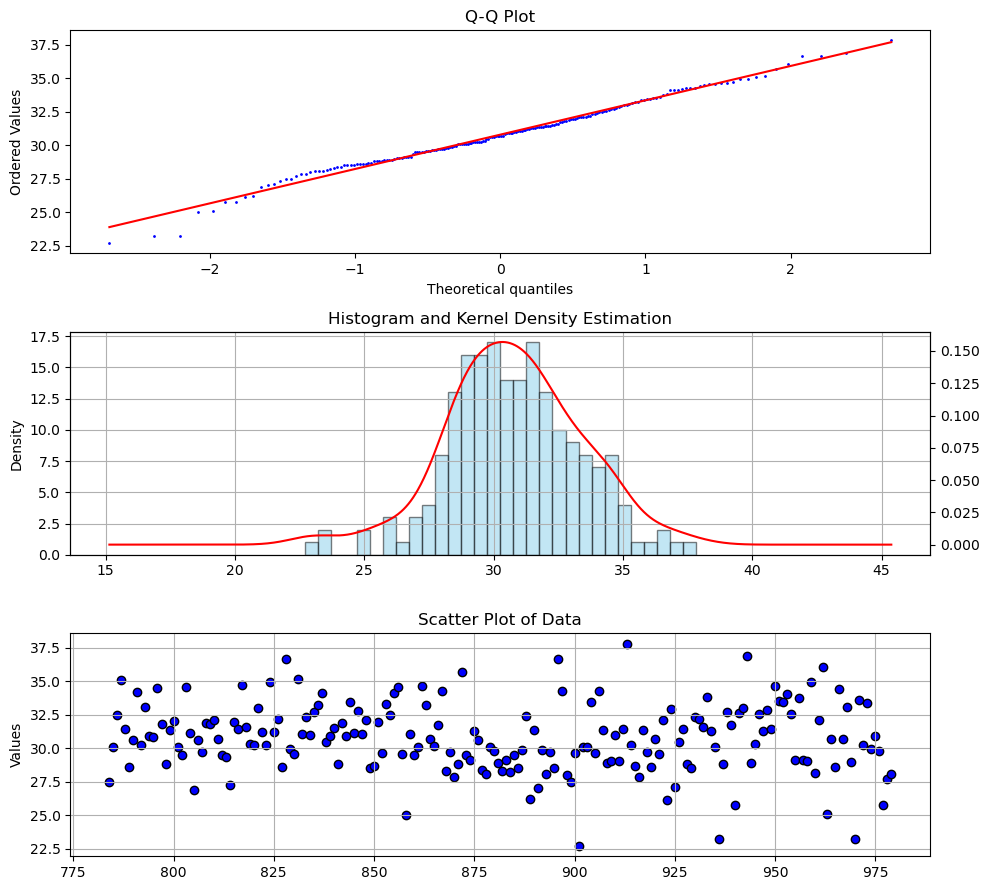

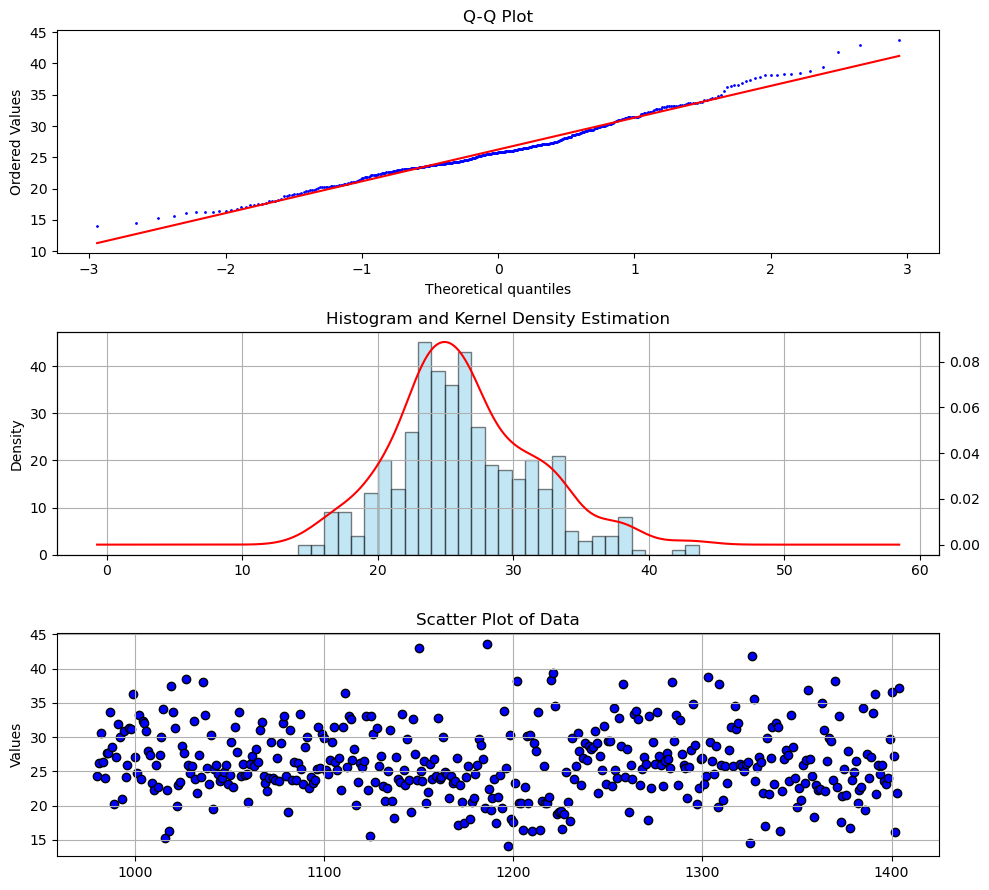

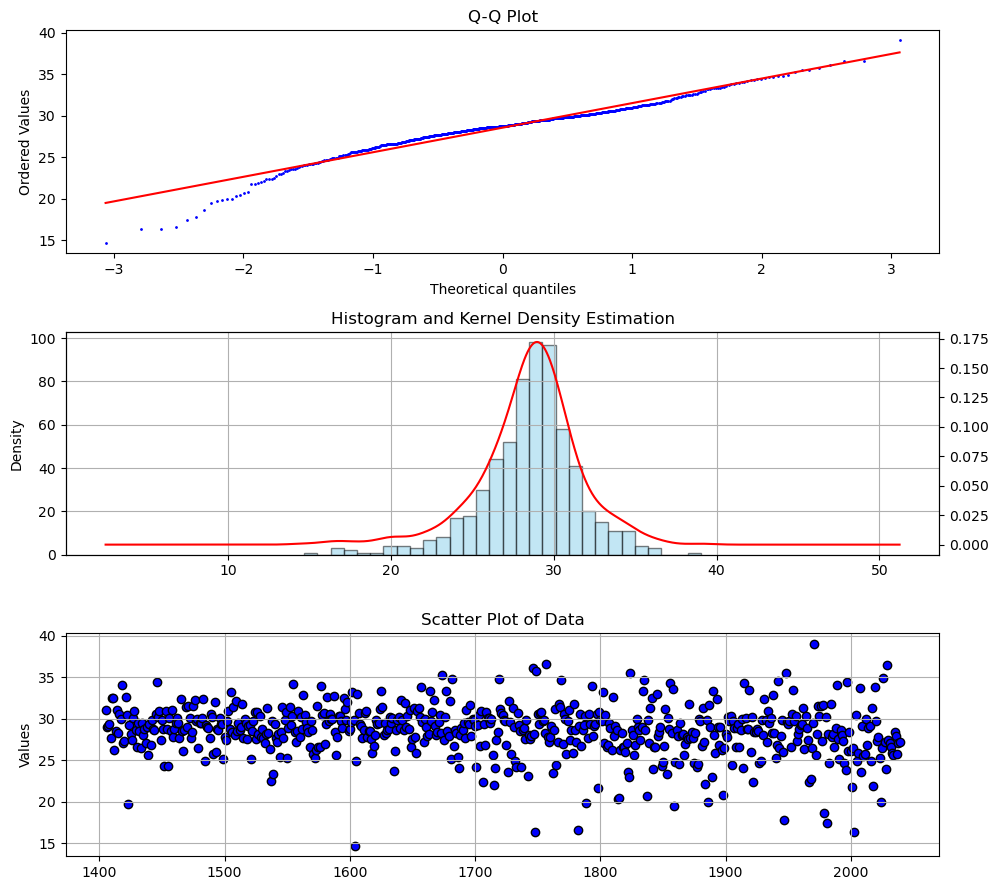

In [5]:
for i in sorted(df['群类别'].unique()):
    data = df[df['群类别']==i]
    # 画图
    plot_data_normality(data['平均年龄'], f'exp3.2.{i}')
    # kstest正态性检验
    print(f"The p-value of category {i} by kstest: {kstest(data.iloc[:, 6]).pvalue}")
    print(f"The std of category {i}: {data.iloc[:, 6].std()}\n")

### 实验3.3
对$\text{Col}[7]$进行单因素方差分析（ANOVA），其中类别来自$\text{Col}[2]$。记下你的结论、支持的统计数据。

In [6]:
one_way_ANOVA(df, '群类别')

Group 1: n=484, mean=23.40, std=4.92, var=24.24
Group 2: n=300, mean=29.62, std=5.22, var=27.22
Group 3: n=196, mean=30.79, std=2.55, var=6.52
Group 4: n=425, mean=26.26, std=5.10, var=25.99
Group 5: n=635, mean=28.55, std=3.02, var=9.11
Overall: n=2040, mean=27.22, std=4.99, var=24.87
SS_between=12782.92, SS_within=37918.62, Total_SS=50701.54
MS_between=3195.73, MS_within=18.63
F_value=171.51, p_value=1.08e-126


### 实验4
选择另外三列，绘制每个特征列的pdf函数，并测试哪一列满足问题1中的假设？它们对应的对数变换结果如何？

选择的列为：['会话数', '无回应比例', '夜聊比例']
列名为：会话数
The p-value of column 会话数 by kstest: 2.897179974105013e-113
The std of category 1: 188.53432882490648

The std of category 2: 159.58977298381504

The std of category 3: 144.11570615605427

The std of category 4: 80.9779107601362

The std of category 5: 157.3733507755215

对数变化后：
The p-value of column 会话数 by kstest: 6.41210684289512e-06
The std of category 1: 1.8836768450825747

The std of category 2: 1.9050840780814653

The std of category 3: 1.5449780447660233

The std of category 4: 1.569836864282565

The std of category 5: 1.6018207171140457

列名为：无回应比例
The p-value of column 无回应比例 by kstest: 1.4513645885189616e-20
The std of category 1: 0.25498813020172306

The std of category 2: 0.2424000798092768

The std of category 3: 0.21656279771415074

The std of category 4: 0.24053425553614582

The std of category 5: 0.19620044410848875

对数变化后：
The p-value of column 无回应比例 by kstest: 1.1365642511940491e-35
The std of category 1: 0.44424855388939677

The st

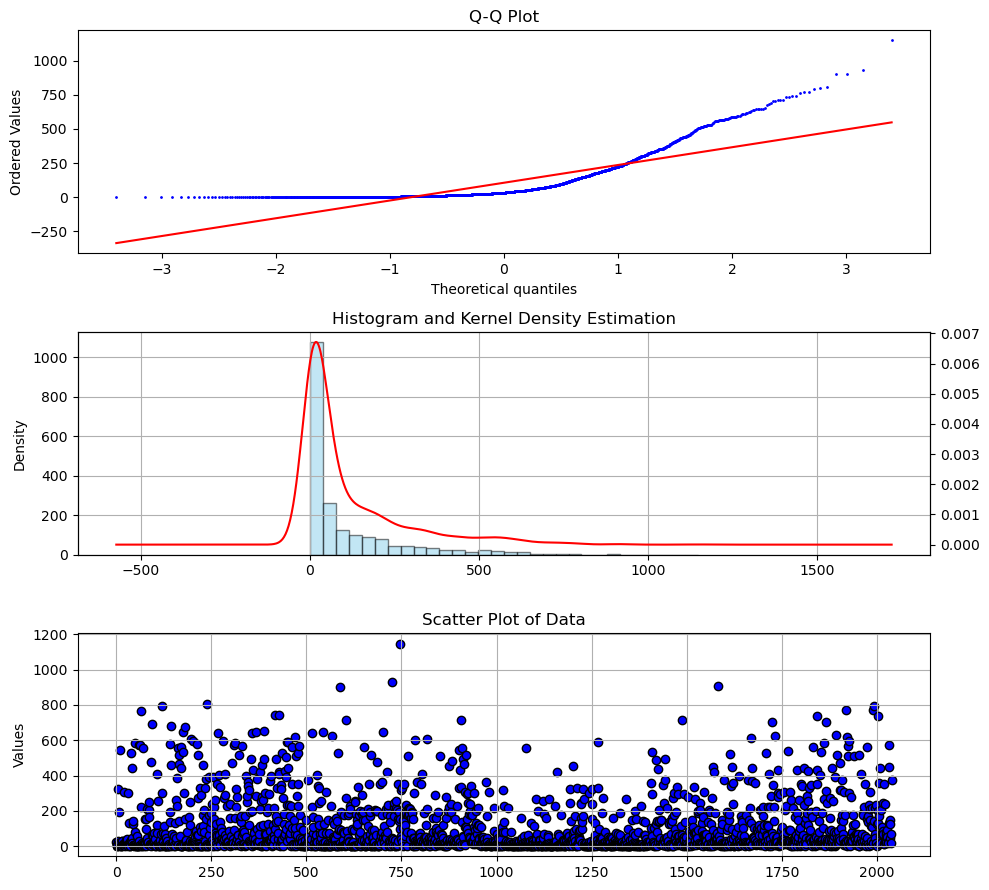

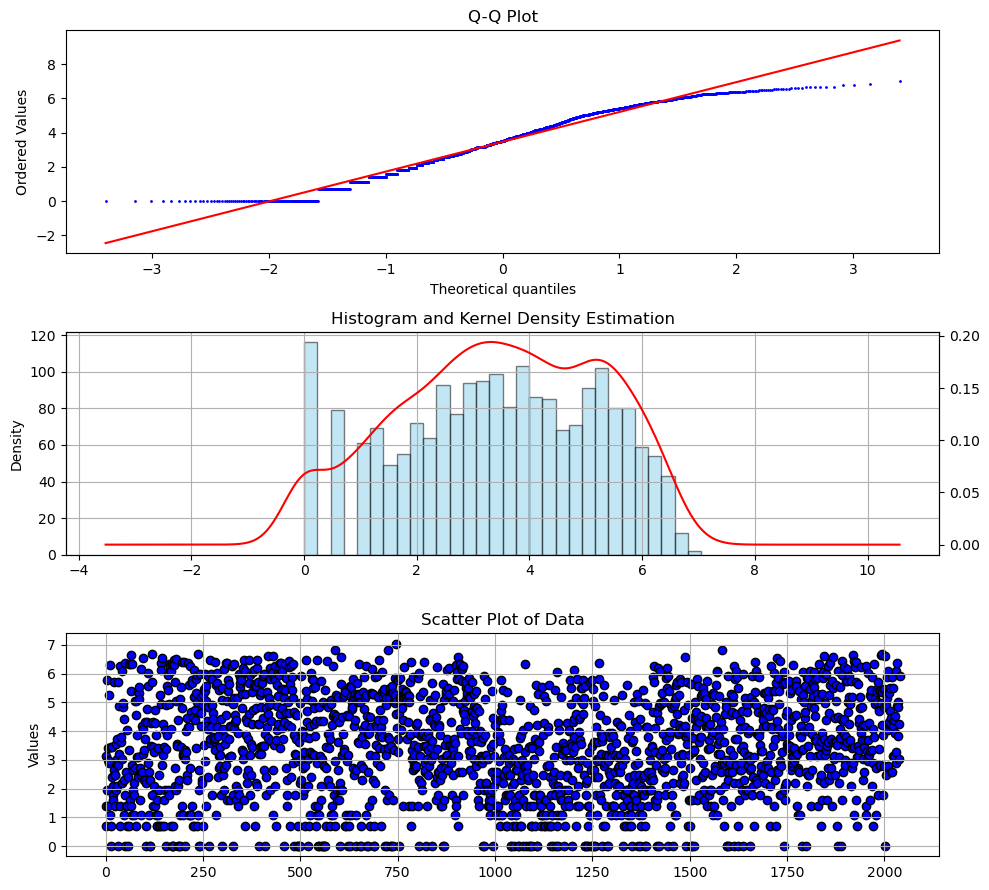

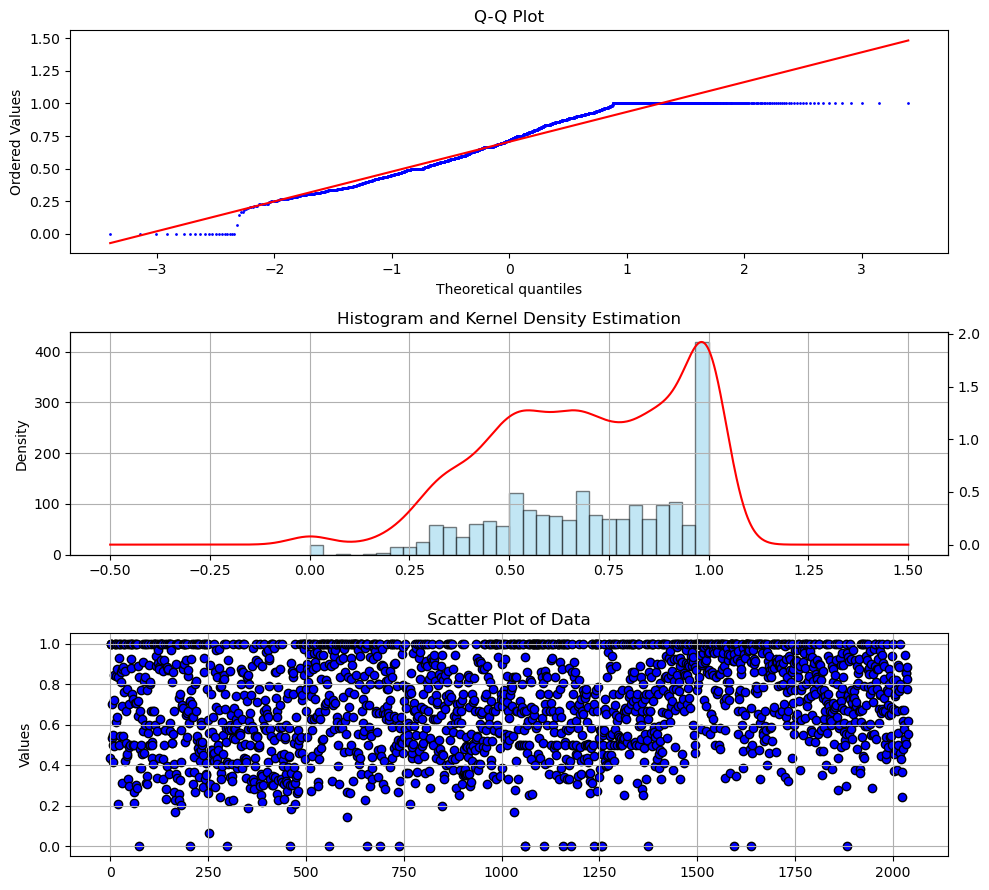

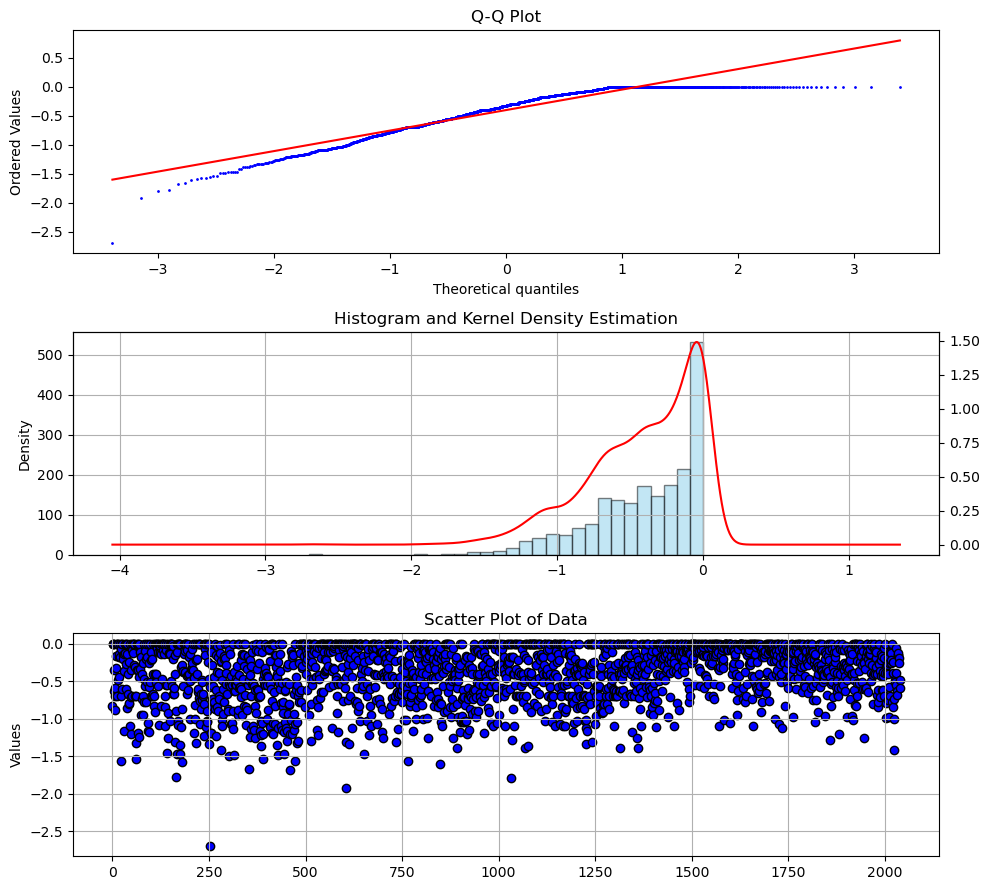

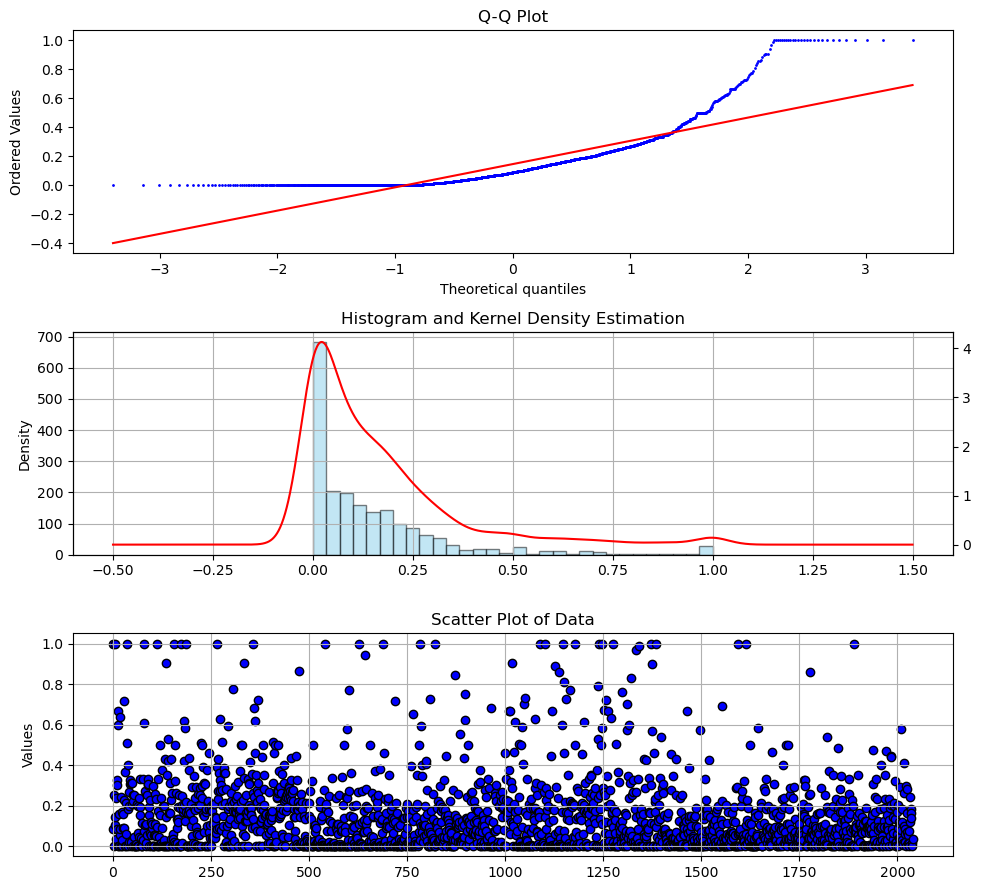

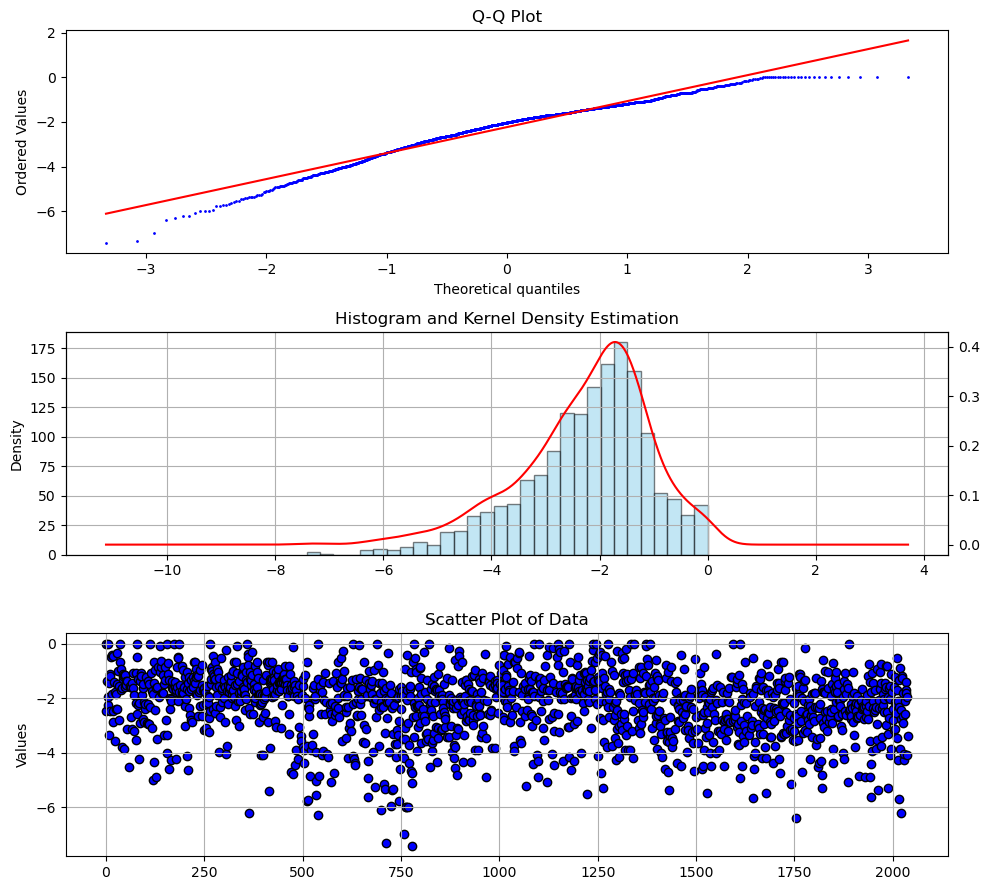

In [7]:
choose_column = list(df.columns[-4:-1])
print(f"选择的列为：{choose_column}")

for column in choose_column:
    print(f"列名为：{column}")
    plot_data_normality(df[column], f'exp4.{column}')
    print(f"The p-value of column {column} by kstest: {kstest(df[column]).pvalue}")
    for i in sorted(df['群类别'].unique()):
        data = df[df['群类别']==i]
        print(f"The std of category {i}: {data[column].std()}\n")
        
    print("对数变化后：")
    df_log = df[column][df[column] > 0].apply(np.log)
    plot_data_normality(df_log, f'exp4.{column}_log')
    print(f"The p-value of column {column} by kstest: {kstest(df_log).pvalue}")
    for i in sorted(df['群类别'].unique()):
        data = df[df['群类别']==i]
        df_log = data[column][data[column] > 0].apply(np.log)
        print(f"The std of category {i}: {df_log.std()}\n")

### 实验五
对你选择的三列进行单因素方差分析。这些特征列的变化显著吗？可视化结果。

In [8]:
for column in choose_column:
    print(f"列名为：{column}")
    one_way_ANOVA(df, '群类别', column)
    print("\n")

列名为：会话数
Group 1: n=484, mean=141.35, std=188.53, var=35545.19
Group 2: n=300, mean=113.40, std=159.59, var=25468.90
Group 3: n=196, mean=104.23, std=144.12, var=20769.34
Group 4: n=425, mean=44.01, std=80.98, var=6557.42
Group 5: n=635, mean=117.66, std=157.37, var=24766.37
Overall: n=2040, mean=106.02, std=156.06, var=24353.67
SS_between=2341365.80, SS_within=47315775.25, Total_SS=49657141.05
MS_between=585341.45, MS_within=23251.00
F_value=25.17, p_value=2.22e-20


列名为：无回应比例
Group 1: n=484, mean=0.64, std=0.25, var=0.07
Group 2: n=300, mean=0.72, std=0.24, var=0.06
Group 3: n=196, mean=0.66, std=0.22, var=0.05
Group 4: n=425, mean=0.68, std=0.24, var=0.06
Group 5: n=635, mean=0.78, std=0.20, var=0.04
Overall: n=2040, mean=0.71, std=0.24, var=0.06
SS_between=6.69, SS_within=107.05, Total_SS=113.74
MS_between=1.67, MS_within=0.05
F_value=31.79, p_value=1.00e-25


列名为：夜聊比例
Group 1: n=484, mean=0.20, std=0.20, var=0.04
Group 2: n=300, mean=0.10, std=0.16, var=0.03
Group 3: n=196, mean=0.